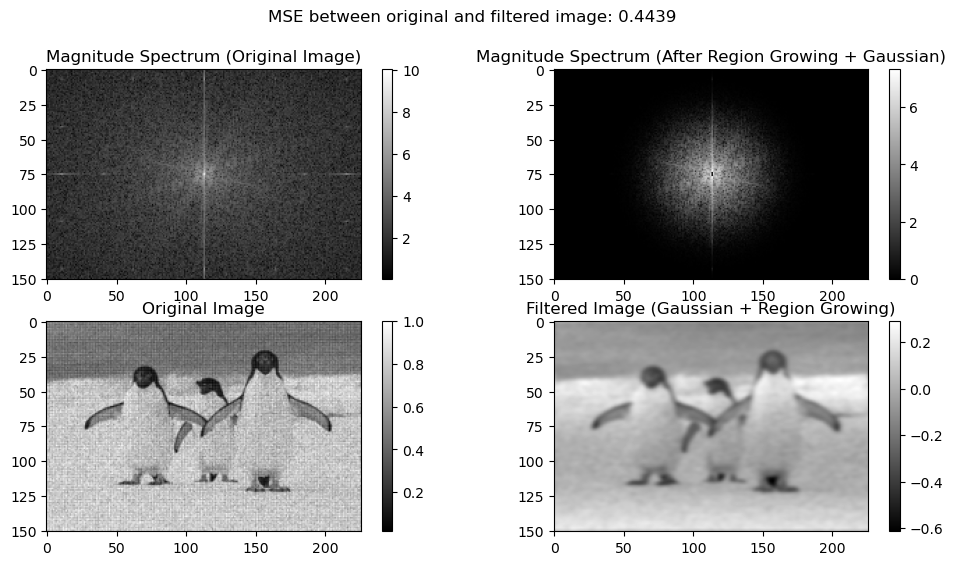

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import io, color
from scipy.ndimage import gaussian_filter

# Load Image (supports BMP format)
image_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\distortedimage.bmp'  # Update file path
image = io.imread(image_path)

# Convert to grayscale if needed
if len(image.shape) == 3:
    image = color.rgb2gray(image)

# Normalize image
image = image / np.max(image)

# Apply FFT
dft_image = fft2(image)
dft_shifted = fftshift(dft_image)  # Shift to center

# Apply Gaussian Blur in Frequency Domain
def gaussian_low_pass_filter(shape, sigma):
    M, N = shape
    x = np.linspace(-N//2, N//2, N)
    y = np.linspace(-M//2, M//2, M)
    X, Y = np.meshgrid(x, y)
    gaussian_filter = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return gaussian_filter

# Define Region Growing Algorithm for Frequency Domain Filtering
def region_growing_dft(dft_image, seed, threshold):
    M, N = dft_image.shape
    mask = np.zeros((M, N), dtype=bool)
    to_visit = [seed]
    
    while to_visit:
        x, y = to_visit.pop()
        if mask[x, y]:  # Already visited
            continue
        mask[x, y] = True  # Mark as visited

        # Check neighbors in 8 directions
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < M and 0 <= ny < N:
                    if not mask[nx, ny] and np.abs(dft_image[nx, ny]) > threshold:
                        to_visit.append((nx, ny))  # Add to the queue

    # Apply mask to DFT (actual filtering effect)
    filtered_dft = np.copy(dft_image)
    filtered_dft[mask] = 0  # Suppress selected frequencies
    return filtered_dft

# Get center of frequency domain as seed
center = (dft_shifted.shape[0]//2, dft_shifted.shape[1]//2)

# Apply Gaussian Filter in DFT
sigma = 20  # Adjust this for stronger/weaker blurring
gaussian_filter_mask = gaussian_low_pass_filter(dft_shifted.shape, sigma)

# Apply Gaussian Filter by multiplying in the frequency domain
dft_blurred = dft_shifted * gaussian_filter_mask

# Apply Region Growing Filtering
dynamic_threshold = np.max(np.abs(dft_blurred)) * 0.1
filtered_dft = region_growing_dft(dft_blurred, seed=center, threshold=dynamic_threshold)

# Apply Inverse FFT
filtered_image = np.real(ifft2(ifftshift(filtered_dft)))

# Compute MSE properly
def compute_mse(original, filtered):
    return np.mean((original - filtered) ** 2)

mse_value = compute_mse(image, filtered_image)

# Plot Results
plt.figure(figsize=(12, 6))

# Original DFT Magnitude Spectrum
plt.subplot(2, 2, 1)
plt.imshow(np.log1p(np.abs(dft_shifted)), cmap='gray')
plt.colorbar()
plt.title("Magnitude Spectrum (Original Image)")

# Filtered DFT Magnitude Spectrum
plt.subplot(2, 2, 2)
plt.imshow(np.log1p(np.abs(filtered_dft)), cmap='gray')
plt.colorbar()
plt.title("Magnitude Spectrum (After Region Growing + Gaussian)")

# Original Image
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title("Original Image")

# Filtered Image
plt.subplot(2, 2, 4)
plt.imshow(filtered_image, cmap='gray')
plt.colorbar()
plt.title("Filtered Image (Gaussian + Region Growing)")

# Display MSE
plt.suptitle(f"MSE between original and filtered image: {mse_value:.4f}")

plt.show()


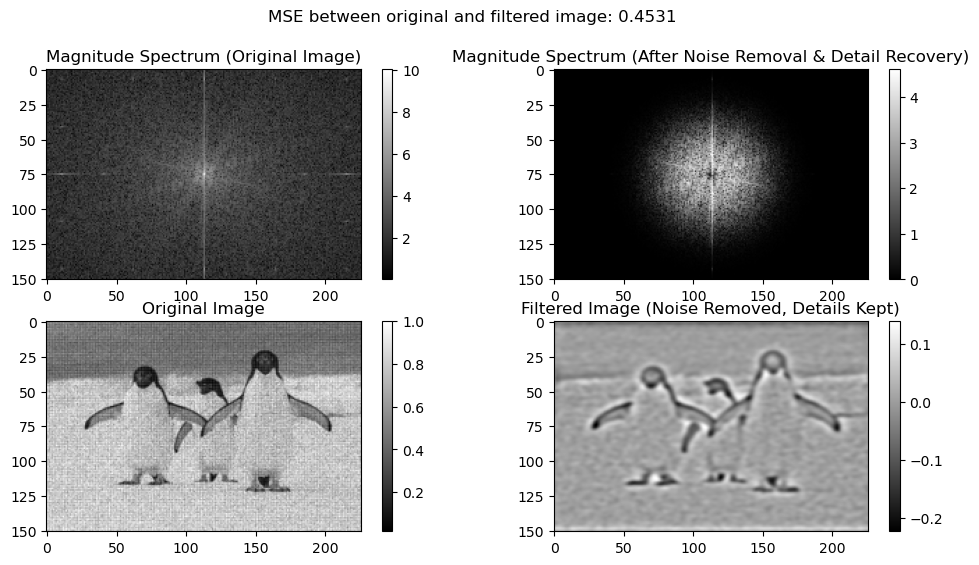

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import io, color

# Load Image
image_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\distortedimage.bmp'
image = io.imread(image_path)

# Convert to grayscale if needed
if len(image.shape) == 3:
    image = color.rgb2gray(image)

# Normalize image
image = image / np.max(image)

# Apply FFT
dft_image = fft2(image)
dft_shifted = fftshift(dft_image)

# Gaussian Low-Pass Filter
def gaussian_low_pass(shape, sigma):
    M, N = shape
    x = np.linspace(-N//2, N//2, N)
    y = np.linspace(-M//2, M//2, M)
    X, Y = np.meshgrid(x, y)
    return np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# High-Pass Filter to restore details
def high_pass_filter(shape, cutoff):
    M, N = shape
    x = np.linspace(-N//2, N//2, N)
    y = np.linspace(-M//2, M//2, M)
    X, Y = np.meshgrid(x, y)
    return 1 - np.exp(-(X**2 + Y**2) / (2 * cutoff**2))  # Keeps high-frequencies

# Create filters
sigma = 20  # Controls how much noise is removed
cutoff = 10  # Controls how much detail is restored
low_pass = gaussian_low_pass(dft_shifted.shape, sigma)
high_pass = high_pass_filter(dft_shifted.shape, cutoff)

# Apply Gaussian Blur (Noise Removal)
dft_blurred = dft_shifted * low_pass

# Apply High-Pass Filter (Restores Detail)
dft_sharpened = dft_blurred * high_pass

# Apply Inverse FFT
filtered_image = np.real(ifft2(ifftshift(dft_sharpened)))

# Compute MSE
mse_value = np.mean((image - filtered_image) ** 2)

# Plot Results
plt.figure(figsize=(12, 6))

# Original DFT Magnitude Spectrum
plt.subplot(2, 2, 1)
plt.imshow(np.log1p(np.abs(dft_shifted)), cmap='gray')
plt.colorbar()
plt.title("Magnitude Spectrum (Original Image)")

# Filtered DFT Magnitude Spectrum
plt.subplot(2, 2, 2)
plt.imshow(np.log1p(np.abs(dft_sharpened)), cmap='gray')
plt.colorbar()
plt.title("Magnitude Spectrum (After Noise Removal & Detail Recovery)")

# Original Image
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title("Original Image")

# Filtered Image
plt.subplot(2, 2, 4)
plt.imshow(filtered_image, cmap='gray')
plt.colorbar()
plt.title("Filtered Image (Noise Removed, Details Kept)")

# Display MSE
plt.suptitle(f"MSE between original and filtered image: {mse_value:.4f}")

plt.show()


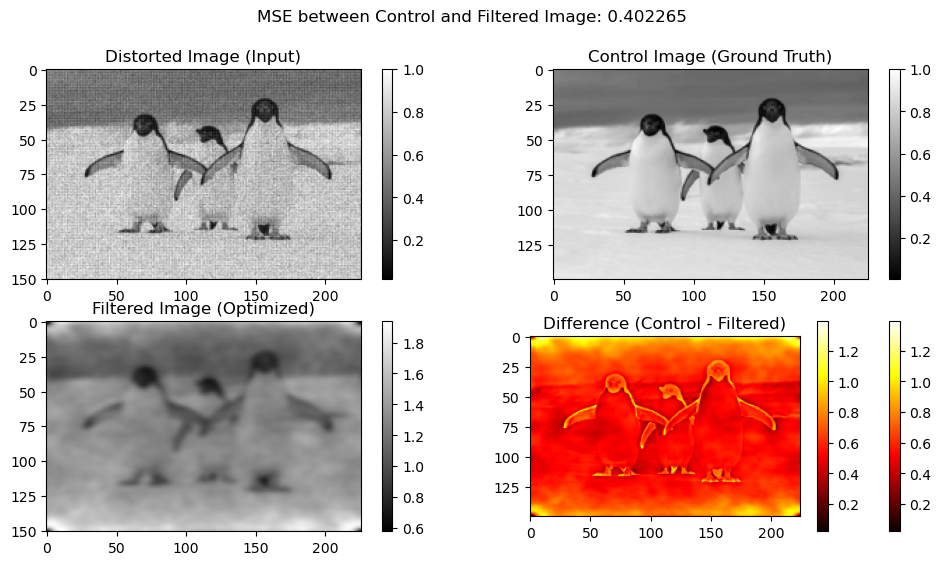

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from skimage import io, color, filters

# Load Control Image & Distorted Image
control_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\controlpenguin.bmp'
distorted_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\distortedimage.bmp'

control_image = io.imread(control_path)
distorted_image = io.imread(distorted_path)

# Convert to grayscale if needed
if len(control_image.shape) == 3:
    control_image = color.rgb2gray(control_image)
if len(distorted_image.shape) == 3:
    distorted_image = color.rgb2gray(distorted_image)

# Normalize images
control_image = control_image / np.max(control_image)
distorted_image = distorted_image / np.max(distorted_image)

# Apply FFT
dft_control = fft2(control_image)
dft_distorted = fft2(distorted_image)
dft_shifted_distorted = fftshift(dft_distorted)

# Gaussian Low-Pass Filter (to remove noise)
def gaussian_low_pass(shape, sigma):
    M, N = shape
    x = np.linspace(-N//2, N//2, N)
    y = np.linspace(-M//2, M//2, M)
    X, Y = np.meshgrid(x, y)
    return np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# Adaptive High-Pass Filter (to restore details)
def adaptive_high_pass(dft, sigma=10):
    blurred = gaussian_filter(np.abs(dft), sigma=sigma)  # Apply Gaussian blur
    return np.abs(dft) - blurred  # Subtract blurred version to keep edges

# Apply Gaussian Filter to Remove Noise
sigma = 15  # Higher sigma removes more noise
low_pass_filter = gaussian_low_pass(dft_shifted_distorted.shape, sigma)
dft_filtered = dft_shifted_distorted * low_pass_filter  # Apply filter in frequency domain

# Apply Adaptive High-Pass Filter to Restore Details
dft_sharpened = dft_filtered + adaptive_high_pass(dft_filtered, sigma=8)

# Inverse FFT to get the final filtered image
filtered_image = np.real(ifft2(ifftshift(dft_sharpened)))

# Compute MSE between Control and Filtered Image
from skimage.transform import resize

# Resize filtered image to match control image dimensions
filtered_image_resized = resize(filtered_image, control_image.shape, mode='reflect', anti_aliasing=True)

# Compute MSE
mse_value = np.mean((control_image - filtered_image_resized) ** 2)


# Plot Results
plt.figure(figsize=(12, 6))

# Original Distorted Image
plt.subplot(2, 2, 1)
plt.imshow(distorted_image, cmap='gray')
plt.colorbar()
plt.title("Distorted Image (Input)")

# Control Image
plt.subplot(2, 2, 2)
plt.imshow(control_image, cmap='gray')
plt.colorbar()
plt.title("Control Image (Ground Truth)")

# Filtered Image (After Noise Removal & Detail Recovery)
plt.subplot(2, 2, 3)
plt.imshow(filtered_image, cmap='gray')
plt.colorbar()
plt.title("Filtered Image (Optimized)")

# Difference Map (Control vs. Filtered)
plt.subplot(2, 2, 4)
from skimage.transform import resize

# Resize filtered image to match control image dimensions
filtered_image_resized = resize(filtered_image, control_image.shape, mode='reflect', anti_aliasing=True)

# Now compute the difference
plt.imshow(np.abs(control_image - filtered_image_resized), cmap='hot')
plt.colorbar()
plt.title("Difference (Control - Filtered)")

plt.colorbar()
plt.title("Difference (Control - Filtered)")

# Display MSE
plt.suptitle(f"MSE between Control and Filtered Image: {mse_value:.6f}")

plt.show()


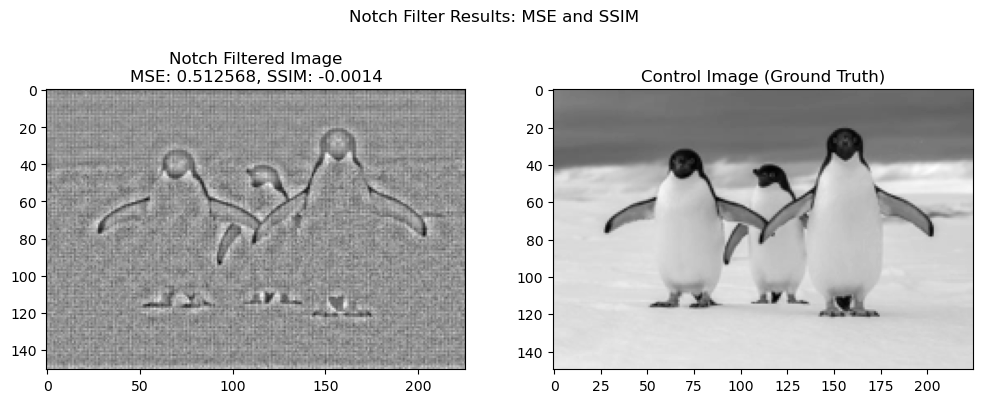

MSE for Notch Filter: 0.512568
SSIM for Notch Filter: -0.0014


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import io, color
from skimage.transform import resize
from skimage import metrics

# Load images
control_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\controlpenguin.bmp'
distorted_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\distortedimage.bmp'

control_image = io.imread(control_path)
distorted_image = io.imread(distorted_path)

# Convert to grayscale if needed
if len(control_image.shape) == 3:
    control_image = color.rgb2gray(control_image)
if len(distorted_image.shape) == 3:
    distorted_image = color.rgb2gray(distorted_image)

# Normalize images
control_image = control_image / np.max(control_image)
distorted_image = distorted_image / np.max(distorted_image)

# Function to apply a Notch Filter
def notch_filter(shape, cutoff_radius=10, center=None):
    M, N = shape
    if center is None:
        center = (M // 2, N // 2)
    
    # Create a meshgrid to define the frequency domain
    y, x = np.ogrid[:M, :N]
    
    # Distance from the center (in frequency space)
    dist_from_center = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    
    # Create the notch filter
    filter = np.ones((M, N))
    filter[dist_from_center <= cutoff_radius] = 0  # Zero out frequencies within the cutoff radius
    return filter

# Apply the Notch Filter to the Fourier Transform of the Image
def apply_nl_notch_filter(image, cutoff_radius=10):
    dft = fft2(image)
    dft_shifted = fftshift(dft)  # Shift the zero frequency component to the center
    
    # Create and apply the notch filter
    filter = notch_filter(dft_shifted.shape, cutoff_radius)
    dft_filtered = dft_shifted * filter
    
    # Inverse FFT to get the filtered image
    filtered_image = np.real(ifft2(ifftshift(dft_filtered)))
    
    return filtered_image

# Apply the Notch Filter to the distorted image
filtered_image_notch = apply_nl_notch_filter(distorted_image, cutoff_radius=15)

# Resize filtered image to match control image dimensions
filtered_image_resized_notch = resize(filtered_image_notch, control_image.shape, mode='reflect', anti_aliasing=True)

# Compute MSE and SSIM for the Notch Filtered Image
def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

mse_notch = compute_mse(control_image, filtered_image_resized_notch)
ssim_notch = metrics.structural_similarity(control_image, filtered_image_resized_notch)

# Display Results
plt.figure(figsize=(12, 8))

# Plot Notch Filtered Image
plt.subplot(2, 2, 1)
plt.imshow(filtered_image_notch, cmap='gray')
plt.title(f"Notch Filtered Image\nMSE: {mse_notch:.6f}, SSIM: {ssim_notch:.4f}")

# Plot Control Image
plt.subplot(2, 2, 2)
plt.imshow(control_image, cmap='gray')
plt.title("Control Image (Ground Truth)")

plt.suptitle(f"Notch Filter Results: MSE and SSIM")
plt.show()

# Print MSE and SSIM for the Notch Filter
print(f"MSE for Notch Filter: {mse_notch:.6f}")
print(f"SSIM for Notch Filter: {ssim_notch:.4f}")


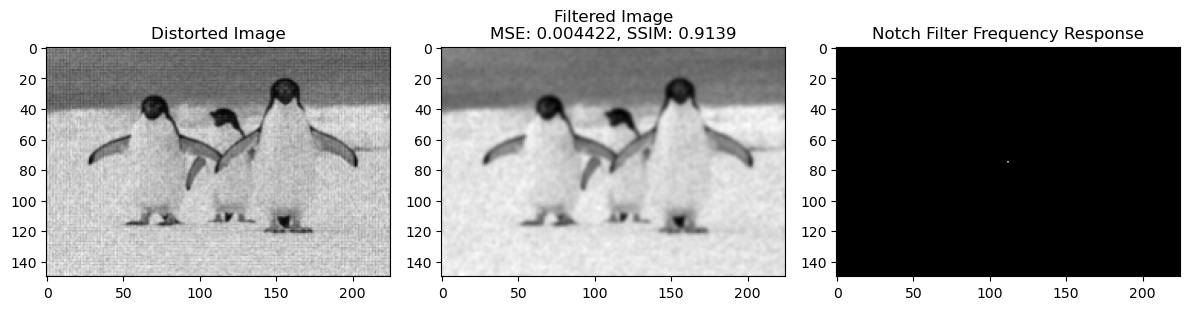

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from skimage import io, color, metrics
from skimage.transform import resize

# Function to compute Mean Squared Error
def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

# Function to compute Structural Similarity Index
def compute_ssim(image1, image2):
    return metrics.structural_similarity(image1, image2)

# Function to create a 2D Gaussian filter
def gaussian_kernel(size, sigma):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

# Function to apply a notch filter in the frequency domain
def notch_filter(dft_shifted, u, v, f0, Q):
    rows, cols = dft_shifted.shape
    center_row, center_col = rows // 2, cols // 2
    U, V = np.meshgrid(u - center_row, v - center_col, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    filter_mask = np.ones((rows, cols))
    filter_mask[D <= f0] = 0
    return dft_shifted * filter_mask

# Load and preprocess images
control_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\controlpenguin.bmp'
distorted_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\distortedimage.bmp'

control_image = io.imread(control_path)
distorted_image = io.imread(distorted_path)

if len(control_image.shape) == 3:
    control_image = color.rgb2gray(control_image)
if len(distorted_image.shape) == 3:
    distorted_image = color.rgb2gray(distorted_image)

control_image = control_image / np.max(control_image)
distorted_image = distorted_image / np.max(distorted_image)

# Resize distorted image to match control image dimensions
distorted_image_resized = resize(distorted_image, control_image.shape, mode='reflect', anti_aliasing=True)

# Apply Gaussian Filter
sigma = 1  # Adjust as needed for subtlety
distorted_image_gaussian = gaussian_filter(distorted_image_resized, sigma=sigma)

# Compute FFT of the Gaussian-filtered image
dft_gaussian = fft2(distorted_image_gaussian)
dft_shifted_gaussian = fftshift(dft_gaussian)

# Define notch filter parameters
f0 = 0.1  # Frequency to remove (normalized)
Q = 50    # Quality factor (higher Q for a narrower notch)
u = np.fft.fftfreq(dft_shifted_gaussian.shape[0])
v = np.fft.fftfreq(dft_shifted_gaussian.shape[1])

# Apply the notch filter in the frequency domain
dft_filtered = notch_filter(dft_shifted_gaussian, u, v, f0, Q)

# Inverse FFT to obtain the filtered image
filtered_image = np.real(ifft2(ifftshift(dft_filtered)))

# Resize filtered image to match control image dimensions
filtered_image_resized = resize(filtered_image, control_image.shape, mode='reflect', anti_aliasing=True)

# Compute MSE and SSIM
mse_value = compute_mse(control_image, filtered_image_resized)
ssim_value = compute_ssim(control_image, filtered_image_resized)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(distorted_image_resized, cmap='gray')
plt.title("Distorted Image")
plt.subplot(1, 3, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title(f"Filtered Image\nMSE: {mse_value:.6f}, SSIM: {ssim_value:.4f}")
plt.subplot(1, 3, 3)
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fftn(np.ones_like(filtered_image))))), cmap='gray')
plt.title("Notch Filter Frequency Response")
plt.tight_layout()
plt.show()


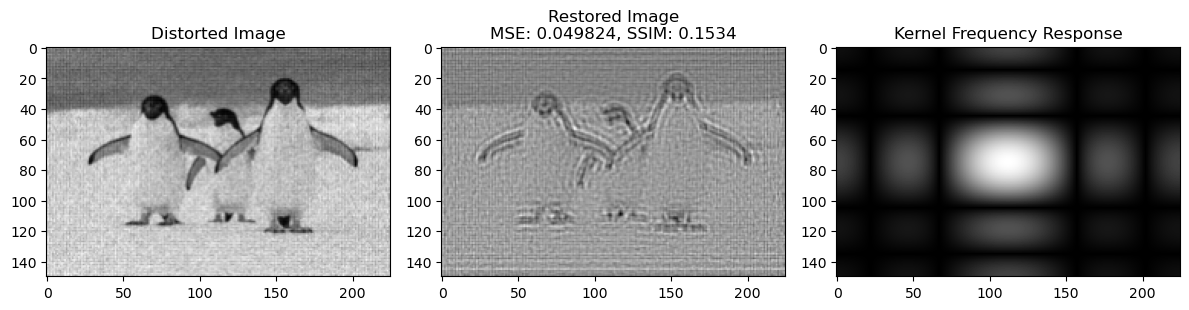

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from skimage import io, color, metrics
from skimage.transform import resize

# Function to compute Mean Squared Error
def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

# Function to compute Structural Similarity Index
def compute_ssim(image1, image2):
    return metrics.structural_similarity(image1, image2)

# Function to apply Wiener Deconvolution in the Frequency Domain
def wiener_deconvolution(dft_image, dft_kernel, K=0.01):
    numerator = np.conj(dft_kernel) * dft_image
    denominator = np.abs(dft_kernel) ** 2 + K
    return numerator / denominator

# Load and preprocess images
control_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\controlpenguin.bmp'
distorted_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\distortedimage.bmp'

control_image = io.imread(control_path)
distorted_image = io.imread(distorted_path)

if len(control_image.shape) == 3:
    control_image = color.rgb2gray(control_image)
if len(distorted_image.shape) == 3:
    distorted_image = color.rgb2gray(distorted_image)

control_image = control_image / np.max(control_image)
distorted_image = distorted_image / np.max(distorted_image)

# Resize distorted image to match control image dimensions
distorted_image_resized = resize(distorted_image, control_image.shape, mode='reflect', anti_aliasing=True)

# Compute FFT of the distorted image
dft_distorted = fft2(distorted_image_resized)
dft_shifted_distorted = fftshift(dft_distorted)

# Create a synthetic blur kernel (e.g., Gaussian blur)
kernel_size = 5
sigma = 1.0
kernel = np.outer(gaussian_filter(np.ones((kernel_size, 1)), sigma), gaussian_filter(np.ones((kernel_size, 1)), sigma))
kernel /= np.sum(kernel)  # Normalize the kernel

# Compute FFT of the kernel
dft_kernel = fft2(kernel, s=distorted_image_resized.shape)
dft_shifted_kernel = fftshift(dft_kernel)

# Apply Wiener Deconvolution in the frequency domain
dft_restored = wiener_deconvolution(dft_shifted_distorted, dft_shifted_kernel)

# Inverse FFT to obtain the restored image
restored_image = np.real(ifft2(ifftshift(dft_restored)))

# Resize restored image to match control image dimensions
restored_image_resized = resize(restored_image, control_image.shape, mode='reflect', anti_aliasing=True)

# Compute MSE and SSIM
mse_value = compute_mse(control_image, restored_image_resized)
ssim_value = compute_ssim(control_image, restored_image_resized)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(distorted_image_resized, cmap='gray')
plt.title("Distorted Image")
plt.subplot(1, 3, 2)
plt.imshow(restored_image_resized, cmap='gray')
plt.title(f"Restored Image\nMSE: {mse_value:.6f}, SSIM: {ssim_value:.4f}")
plt.subplot(1, 3, 3)
plt.imshow(np.log(1 + np.abs(dft_shifted_kernel)), cmap='gray')
plt.title("Kernel Frequency Response")
plt.tight_layout()
plt.show()


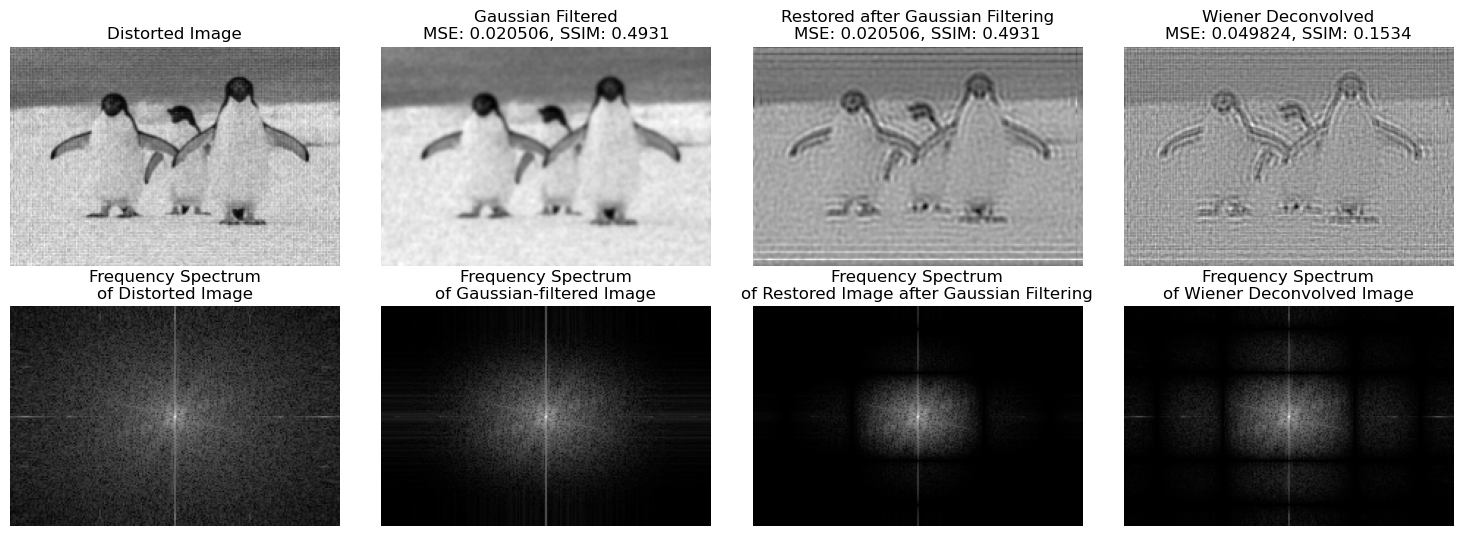

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from skimage import io, color, metrics
from skimage.transform import resize

# Function to compute Mean Squared Error
def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

# Function to compute Structural Similarity Index
def compute_ssim(image1, image2):
    return metrics.structural_similarity(image1, image2)

# Function to apply Wiener Deconvolution in the Frequency Domain
def wiener_deconvolution(dft_image, dft_kernel, K=0.01):
    numerator = np.conj(dft_kernel) * dft_image
    denominator = np.abs(dft_kernel) ** 2 + K
    return numerator / denominator

# Load and preprocess images
control_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\controlpenguin.bmp'
distorted_path = r'C:\Users\OttosMum\Documents\third year\Image Analysis\distortedimage.bmp'

control_image = io.imread(control_path)
distorted_image = io.imread(distorted_path)

if len(control_image.shape) == 3:
    control_image = color.rgb2gray(control_image)
if len(distorted_image.shape) == 3:
    distorted_image = color.rgb2gray(distorted_image)

control_image = control_image / np.max(control_image)
distorted_image = distorted_image / np.max(distorted_image)

# Resize distorted image to match control image dimensions
distorted_image_resized = resize(distorted_image, control_image.shape, mode='reflect', anti_aliasing=True)

# Apply Gaussian filter to the distorted image
sigma = 1.0  # Standard deviation for Gaussian kernel
distorted_image_gaussian = gaussian_filter(distorted_image_resized, sigma=sigma)

# Compute FFT of the Gaussian-filtered image
dft_distorted_gaussian = fft2(distorted_image_gaussian)
dft_shifted_distorted_gaussian = fftshift(dft_distorted_gaussian)

# Create a synthetic blur kernel (e.g., Gaussian blur)
kernel_size = 5
kernel = np.outer(gaussian_filter(np.ones((kernel_size, 1)), sigma), gaussian_filter(np.ones((kernel_size, 1)), sigma))
kernel /= np.sum(kernel)  # Normalize the kernel

# Compute FFT of the kernel
dft_kernel = fft2(kernel, s=distorted_image_resized.shape)
dft_shifted_kernel = fftshift(dft_kernel)

# Apply Wiener Deconvolution in the frequency domain
dft_restored_gaussian = wiener_deconvolution(dft_shifted_distorted_gaussian, dft_shifted_kernel)

# Inverse FFT to obtain the restored image after Gaussian filtering
restored_image_gaussian = np.real(ifft2(ifftshift(dft_restored_gaussian)))

# Compute MSE and SSIM for the Gaussian-filtered image
mse_gaussian = compute_mse(control_image, restored_image_gaussian)
ssim_gaussian = compute_ssim(control_image, restored_image_gaussian)

# Apply Wiener Deconvolution directly to the distorted image
dft_distorted = fft2(distorted_image_resized)
dft_shifted_distorted = fftshift(dft_distorted)
dft_restored = wiener_deconvolution(dft_shifted_distorted, dft_shifted_kernel)
restored_image = np.real(ifft2(ifftshift(dft_restored)))

# Compute MSE and SSIM for the Wiener-deconvolved image
mse_wiener = compute_mse(control_image, restored_image)
ssim_wiener = compute_ssim(control_image, restored_image)

# Plot results
plt.figure(figsize=(15, 8))

# Original Distorted Image
plt.subplot(3, 4, 1)
plt.imshow(distorted_image_resized, cmap='gray')
plt.title("Distorted Image")
plt.axis('off')

# Gaussian-filtered Image
plt.subplot(3, 4, 2)
plt.imshow(distorted_image_gaussian, cmap='gray')
plt.title(f"Gaussian Filtered\nMSE: {mse_gaussian:.6f}, SSIM: {ssim_gaussian:.4f}")
plt.axis('off')

# Restored Image after Gaussian Filtering
plt.subplot(3, 4, 3)
plt.imshow(restored_image_gaussian, cmap='gray')
plt.title(f"Restored after Gaussian Filtering\nMSE: {mse_gaussian:.6f}, SSIM: {ssim_gaussian:.4f}")
plt.axis('off')

# Wiener-deconvolved Image
plt.subplot(3, 4, 4)
plt.imshow(restored_image, cmap='gray')
plt.title(f"Wiener Deconvolved\nMSE: {mse_wiener:.6f}, SSIM: {ssim_wiener:.4f}")
plt.axis('off')

# Frequency Spectrum of Distorted Image
plt.subplot(3, 4, 5)
plt.imshow(np.log(1 + np.abs(dft_shifted_distorted)), cmap='gray')
plt.title("Frequency Spectrum\nof Distorted Image")
plt.axis('off')

# Frequency Spectrum of Gaussian-filtered Image
plt.subplot(3, 4, 6)
plt.imshow(np.log(1 + np.abs(dft_shifted_distorted_gaussian)), cmap='gray')
plt.title("Frequency Spectrum\nof Gaussian-filtered Image")
plt.axis('off')

# Frequency Spectrum of Restored Image after Gaussian Filtering
plt.subplot(3, 4, 7)
plt.imshow(np.log(1 + np.abs(dft_shifted_distorted_gaussian * dft_shifted_kernel)), cmap='gray')
plt.title("Frequency Spectrum\nof Restored Image after Gaussian Filtering")
plt.axis('off')

# Frequency Spectrum of Wiener-deconvolved Image
plt.subplot(3, 4, 8)
plt.imshow(np.log(1 + np.abs(dft_shifted_distorted * dft_shifted_kernel)), cmap='gray')
plt.title("Frequency Spectrum\nof Wiener Deconvolved Image")
plt.axis('off')

plt.tight_layout()
plt.show()


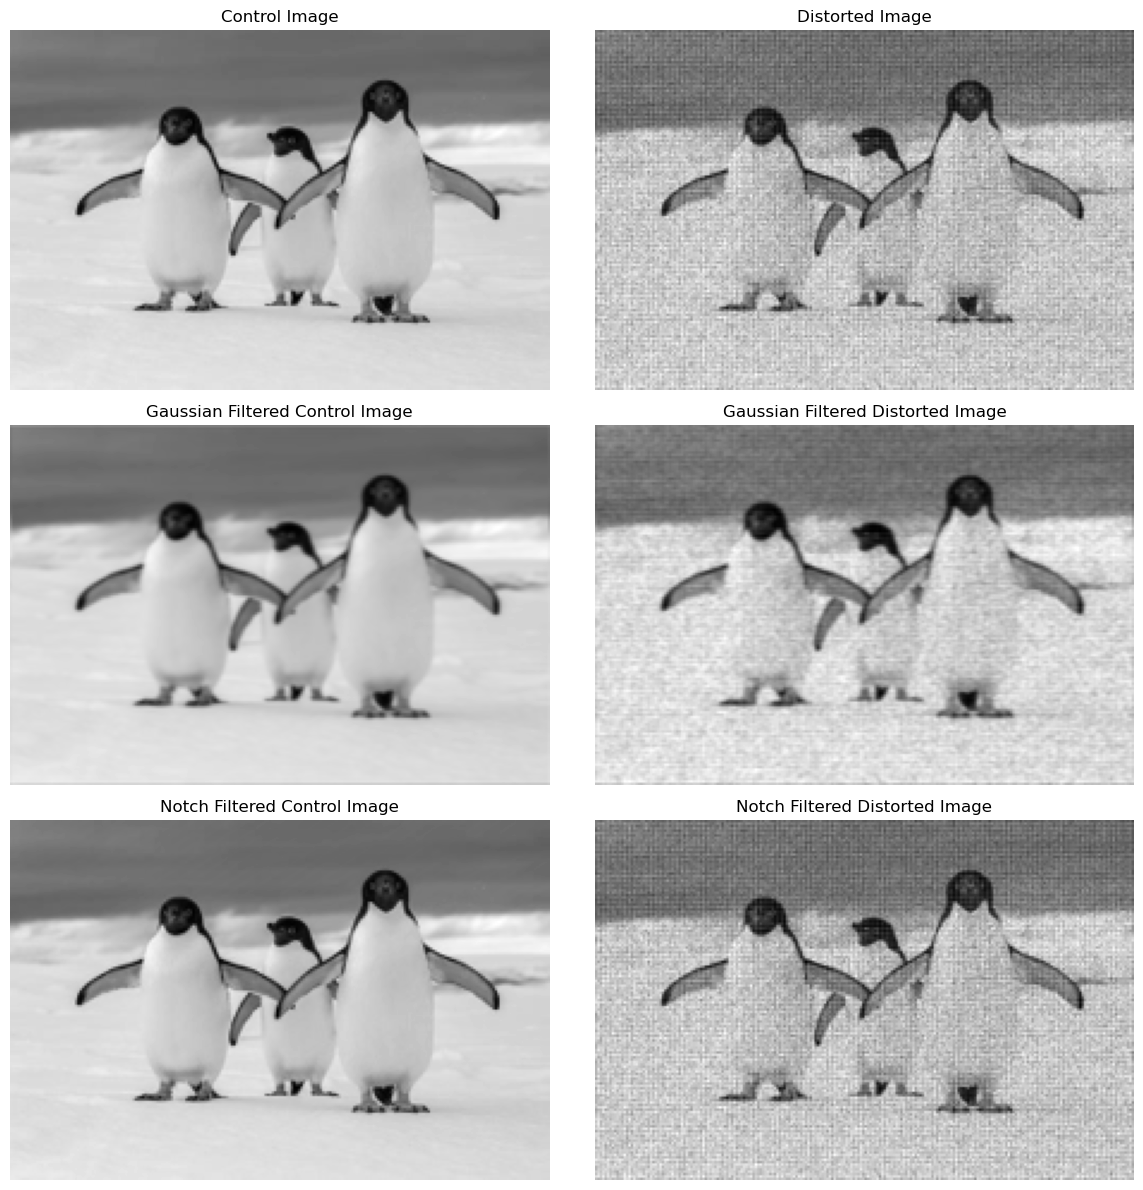

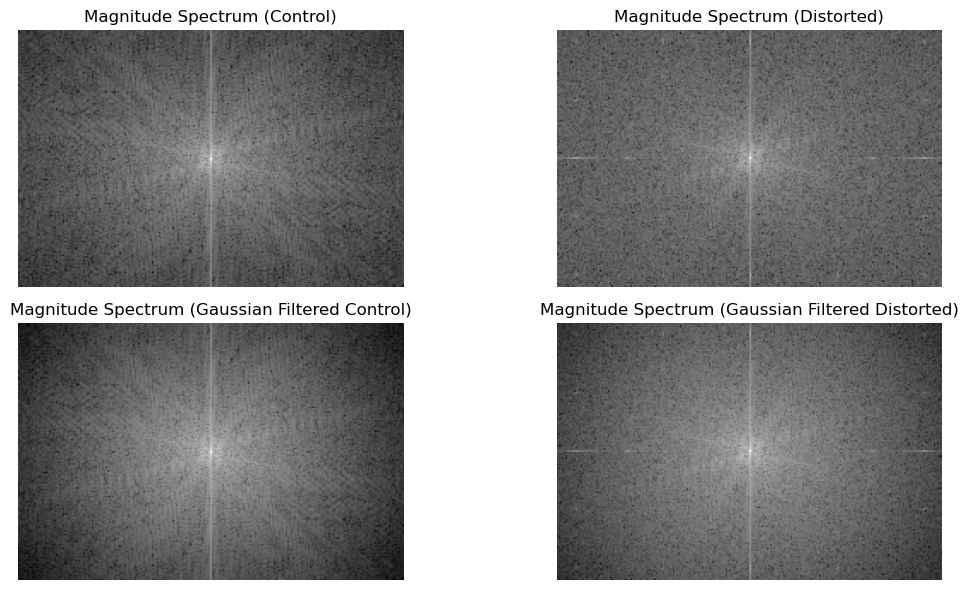

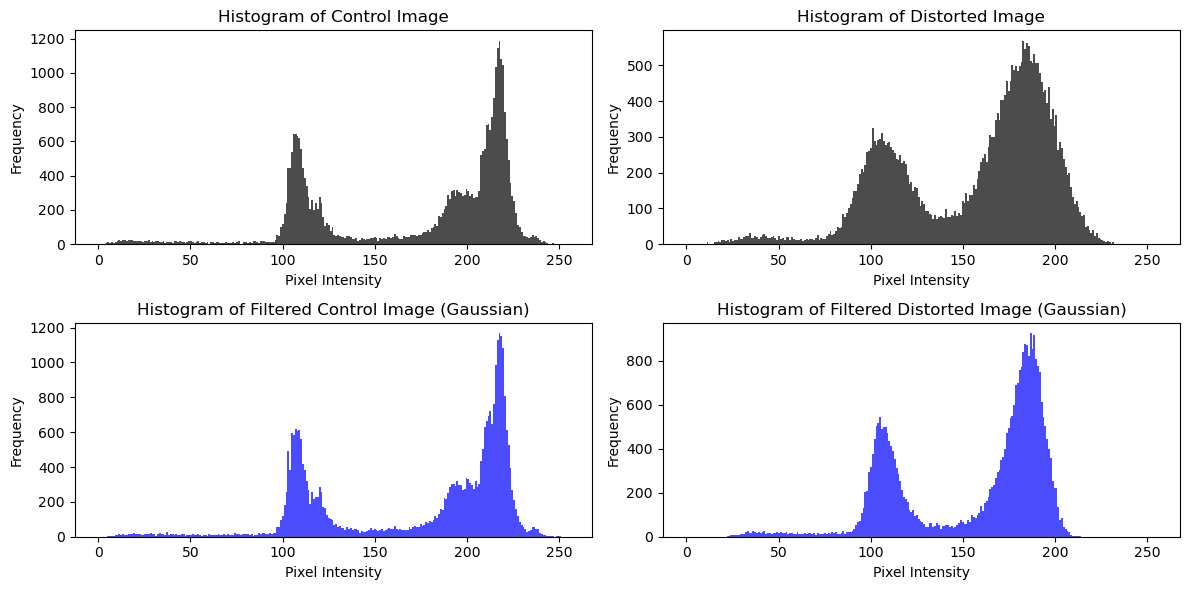

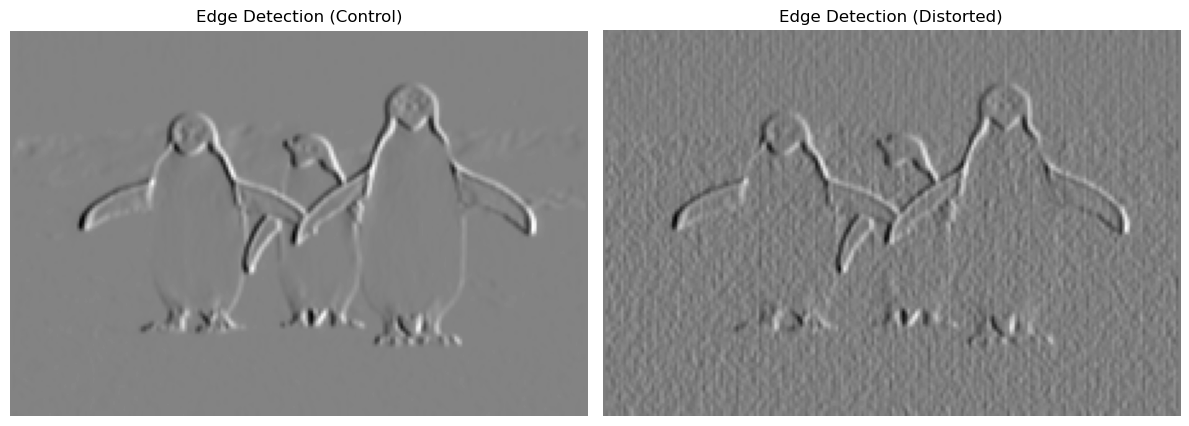

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the control image (grayscale)
image_path_control = 'C:/Users/OttosMum/Documents/third year/Image Analysis/controlpenguin.bmp'
control_image = cv2.imread(image_path_control, cv2.IMREAD_GRAYSCALE)

# Load the distorted image (grayscale)
image_path_distorted = 'C:/Users/OttosMum/Documents/third year/Image Analysis/distortedimage.bmp'
distorted_image = cv2.imread(image_path_distorted, cv2.IMREAD_GRAYSCALE)

# Check if images loaded correctly
if control_image is None or distorted_image is None:
    raise ValueError("One or both images not loaded. Check file paths.")

# Function to apply Gaussian Bandstop Filter
def apply_gaussian_bandstop(image):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Image center

    # FFT and shift to frequency domain
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Create Gaussian Bandstop Filter
    u = np.arange(0, cols)
    v = np.arange(0, rows)
    U, V = np.meshgrid(u, v)
    distance = np.sqrt((U - ccol)**2 + (V - crow)**2)

    sigma = 50  # Standard deviation (adjustable)
    gaussian_filter = np.exp(-(distance**2) / (2 * sigma**2))  # Gaussian function

    # Apply filter
    fshift_filtered = fshift * gaussian_filter

    # Inverse FFT to return to spatial domain
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_filtered = np.abs(np.fft.ifft2(f_ishift))

    return image_filtered, np.log(1 + np.abs(fshift_filtered))  # Also return magnitude spectrum

# Function to apply Notch Filter
def apply_notch_filter(image, notch_coords):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Image center

    # FFT and shift to frequency domain
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Create Notch Filter: Remove specific frequencies
    for (u, v) in notch_coords:
        fshift[crow + u, ccol + v] = 0
        fshift[crow - u, ccol - v] = 0

    # Inverse FFT to return to spatial domain
    f_ishift = np.fft.ifftshift(fshift)
    image_filtered = np.abs(np.fft.ifft2(f_ishift))

    return image_filtered, np.log(1 + np.abs(fshift))  # Also return magnitude spectrum

# Notch filter coordinates (example: frequencies to remove)
# You can adjust these values to target specific frequencies
notch_coords = [(30, 30), (50, 50)]  # These are example notch coordinates, adjust as needed

# Apply Gaussian Bandstop Filter to both images
filtered_control_gaussian, mag_spectrum_control_filtered_gaussian = apply_gaussian_bandstop(control_image)
filtered_distorted_gaussian, mag_spectrum_distorted_filtered_gaussian = apply_gaussian_bandstop(distorted_image)

# Apply Notch Filter to both images
filtered_control_notch, mag_spectrum_control_filtered_notch = apply_notch_filter(control_image, notch_coords)
filtered_distorted_notch, mag_spectrum_distorted_filtered_notch = apply_notch_filter(distorted_image, notch_coords)

# Display original vs filtered images
plt.figure(figsize=(12, 12))

# Control image comparisons
plt.subplot(3, 2, 1)
plt.imshow(control_image, cmap='gray')
plt.title('Control Image')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(filtered_control_gaussian, cmap='gray')
plt.title('Gaussian Filtered Control Image')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(filtered_control_notch, cmap='gray')
plt.title('Notch Filtered Control Image')
plt.axis('off')

# Distorted image comparisons
plt.subplot(3, 2, 2)
plt.imshow(distorted_image, cmap='gray')
plt.title('Distorted Image')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(filtered_distorted_gaussian, cmap='gray')
plt.title('Gaussian Filtered Distorted Image')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(filtered_distorted_notch, cmap='gray')
plt.title('Notch Filtered Distorted Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 2: Magnitude Spectrum Comparison
plt.figure(figsize=(12, 6))

# Magnitude Spectrum comparisons for Gaussian and Notch filters
plt.subplot(2, 2, 1)
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(control_image)))), cmap='gray')
plt.title('Magnitude Spectrum (Control)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(distorted_image)))), cmap='gray')
plt.title('Magnitude Spectrum (Distorted)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mag_spectrum_control_filtered_gaussian, cmap='gray')
plt.title('Magnitude Spectrum (Gaussian Filtered Control)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(mag_spectrum_distorted_filtered_gaussian, cmap='gray')
plt.title('Magnitude Spectrum (Gaussian Filtered Distorted)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 3: Histogram Comparison (Control vs Distorted Images)
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.hist(control_image.ravel(), bins=256, range=(0, 255), color='black', alpha=0.7)
plt.title('Histogram of Control Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(distorted_image.ravel(), bins=256, range=(0, 255), color='black', alpha=0.7)
plt.title('Histogram of Distorted Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(filtered_control_gaussian.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title('Histogram of Filtered Control Image (Gaussian)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(filtered_distorted_gaussian.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title('Histogram of Filtered Distorted Image (Gaussian)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Step 4: Edge Detection (Sobel Operator)
edges_control = cv2.Sobel(control_image, cv2.CV_64F, 1, 0, ksize=3)
edges_distorted = cv2.Sobel(distorted_image, cv2.CV_64F, 1, 0, ksize=3)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(edges_control, cmap='gray')
plt.title('Edge Detection (Control)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges_distorted, cmap='gray')
plt.title('Edge Detection (Distorted)')
plt.axis('off')

plt.tight_layout()
plt.show()


## MSE vs SSIM Comparison

C:\ProgramData\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


MSE (Control Image vs Gaussian Filtered): 23.700692155110413
SSIM (Control Image vs Gaussian Filtered): 0.9828039881515711
MSE (Control Image vs Notch Filtered): 0.029804518095385115
SSIM (Control Image vs Notch Filtered): 0.9996935176611246
MSE (Distorted Image vs Gaussian Filtered): 92.68961655021823
SSIM (Distorted Image vs Gaussian Filtered): 0.7652897354589333
MSE (Distorted Image vs Notch Filtered): 0.03922523715004073
SSIM (Distorted Image vs Notch Filtered): 0.9999191875402518


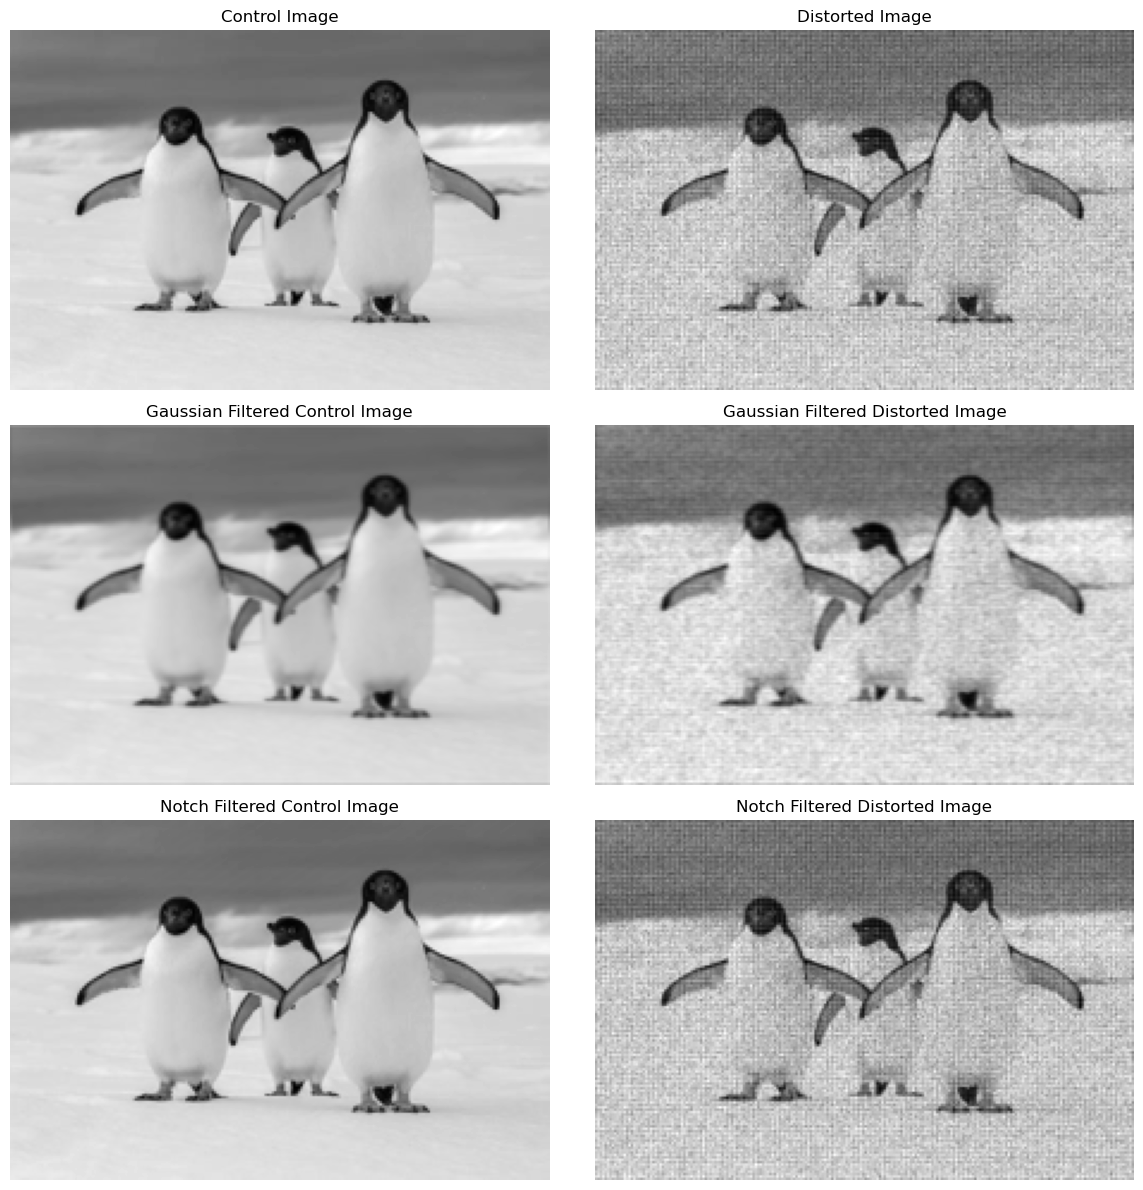

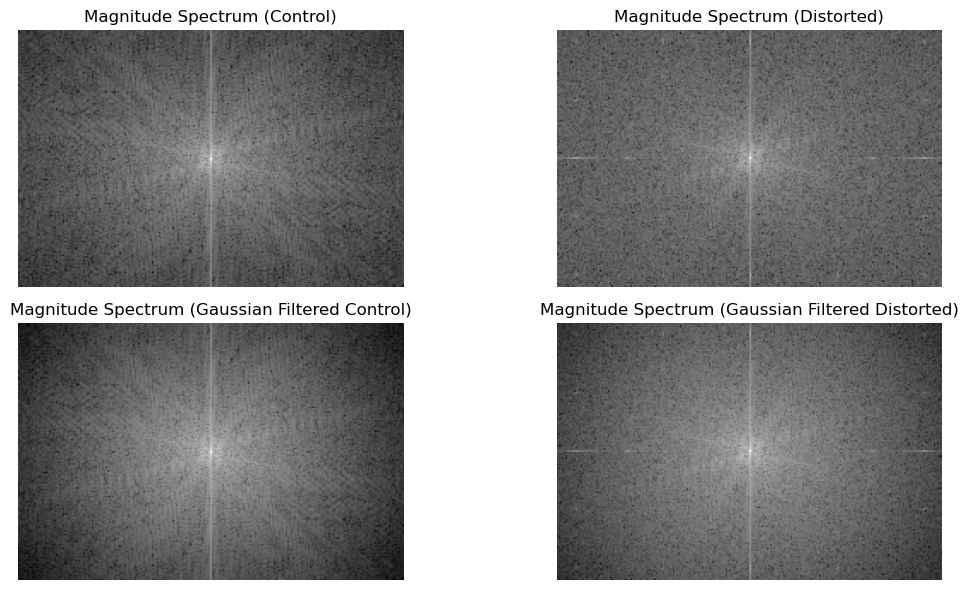

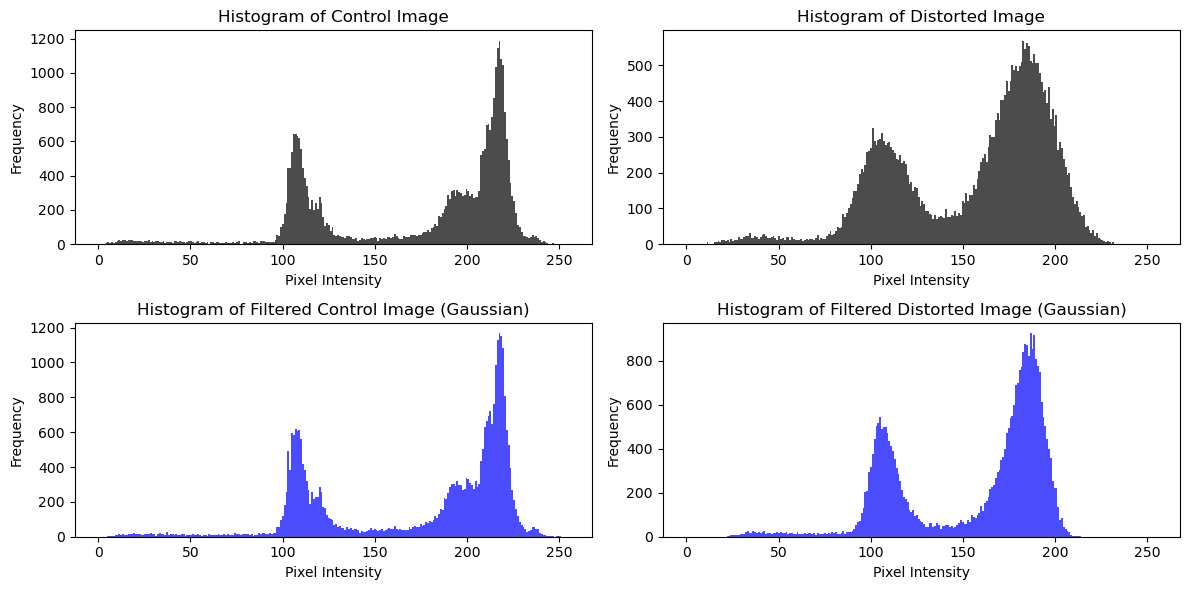

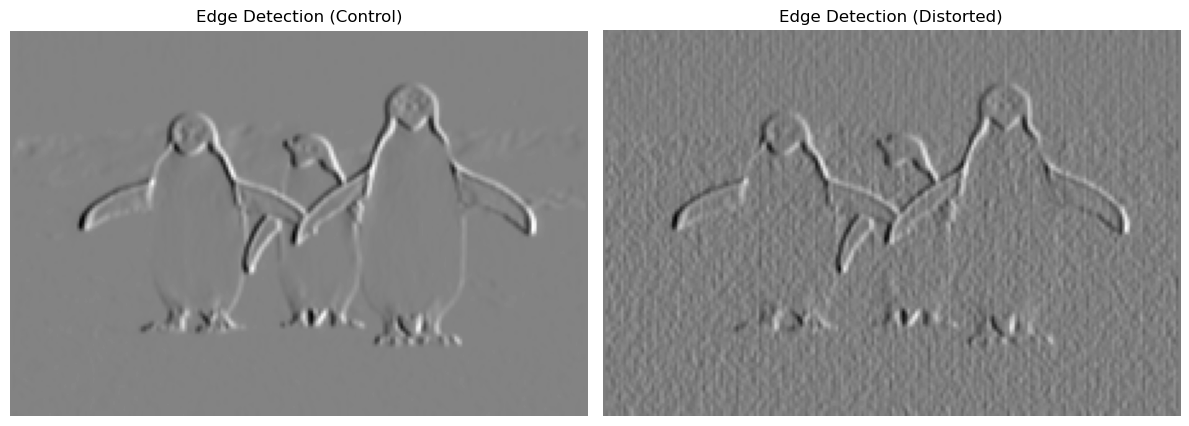

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Load the control image (grayscale)
image_path_control = 'C:/Users/OttosMum/Documents/third year/Image Analysis/controlpenguin.bmp'
control_image = cv2.imread(image_path_control, cv2.IMREAD_GRAYSCALE)

# Load the distorted image (grayscale)
image_path_distorted = 'C:/Users/OttosMum/Documents/third year/Image Analysis/distortedimage.bmp'
distorted_image = cv2.imread(image_path_distorted, cv2.IMREAD_GRAYSCALE)

# Check if images loaded correctly
if control_image is None or distorted_image is None:
    raise ValueError("One or both images not loaded. Check file paths.")

# Function to calculate Mean Squared Error (MSE)
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

# Function to apply Gaussian Bandstop Filter
def apply_gaussian_bandstop(image):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Image center

    # FFT and shift to frequency domain
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Create Gaussian Bandstop Filter
    u = np.arange(0, cols)
    v = np.arange(0, rows)
    U, V = np.meshgrid(u, v)
    distance = np.sqrt((U - ccol)**2 + (V - crow)**2)

    sigma = 50  # Standard deviation (adjustable)
    gaussian_filter = np.exp(-(distance**2) / (2 * sigma**2))  # Gaussian function

    # Apply filter
    fshift_filtered = fshift * gaussian_filter

    # Inverse FFT to return to spatial domain
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_filtered = np.abs(np.fft.ifft2(f_ishift))

    return image_filtered, np.log(1 + np.abs(fshift_filtered))  # Also return magnitude spectrum

# Function to apply Notch Filter
def apply_notch_filter(image, notch_coords):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Image center

    # FFT and shift to frequency domain
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Create Notch Filter: Remove specific frequencies
    for (u, v) in notch_coords:
        fshift[crow + u, ccol + v] = 0
        fshift[crow - u, ccol - v] = 0

    # Inverse FFT to return to spatial domain
    f_ishift = np.fft.ifftshift(fshift)
    image_filtered = np.abs(np.fft.ifft2(f_ishift))

    return image_filtered, np.log(1 + np.abs(fshift))  # Also return magnitude spectrum

# Notch filter coordinates (example: frequencies to remove)
# You can adjust these values to target specific frequencies
notch_coords = [(30, 30), (50, 50)]  # These are example notch coordinates, adjust as needed

# Apply Gaussian Bandstop Filter to both images
filtered_control_gaussian, mag_spectrum_control_filtered_gaussian = apply_gaussian_bandstop(control_image)
filtered_distorted_gaussian, mag_spectrum_distorted_filtered_gaussian = apply_gaussian_bandstop(distorted_image)

# Apply Notch Filter to both images
filtered_control_notch, mag_spectrum_control_filtered_notch = apply_notch_filter(control_image, notch_coords)
filtered_distorted_notch, mag_spectrum_distorted_filtered_notch = apply_notch_filter(distorted_image, notch_coords)

# Calculate MSE and SSIM for the control image and its filtered versions
mse_control_gaussian = mse(control_image, filtered_control_gaussian)
mse_control_notch = mse(control_image, filtered_control_notch)
ssim_control_gaussian = ssim(control_image, filtered_control_gaussian)
ssim_control_notch = ssim(control_image, filtered_control_notch)

# Calculate MSE and SSIM for the distorted image and its filtered versions
mse_distorted_gaussian = mse(distorted_image, filtered_distorted_gaussian)
mse_distorted_notch = mse(distorted_image, filtered_distorted_notch)
ssim_distorted_gaussian = ssim(distorted_image, filtered_distorted_gaussian)
ssim_distorted_notch = ssim(distorted_image, filtered_distorted_notch)

# Print MSE and SSIM values
print(f'MSE (Control Image vs Gaussian Filtered): {mse_control_gaussian}')
print(f'SSIM (Control Image vs Gaussian Filtered): {ssim_control_gaussian}')
print(f'MSE (Control Image vs Notch Filtered): {mse_control_notch}')
print(f'SSIM (Control Image vs Notch Filtered): {ssim_control_notch}')

print(f'MSE (Distorted Image vs Gaussian Filtered): {mse_distorted_gaussian}')
print(f'SSIM (Distorted Image vs Gaussian Filtered): {ssim_distorted_gaussian}')
print(f'MSE (Distorted Image vs Notch Filtered): {mse_distorted_notch}')
print(f'SSIM (Distorted Image vs Notch Filtered): {ssim_distorted_notch}')

# Display original vs filtered images
plt.figure(figsize=(12, 12))

# Control image comparisons
plt.subplot(3, 2, 1)
plt.imshow(control_image, cmap='gray')
plt.title('Control Image')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(filtered_control_gaussian, cmap='gray')
plt.title('Gaussian Filtered Control Image')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(filtered_control_notch, cmap='gray')
plt.title('Notch Filtered Control Image')
plt.axis('off')

# Distorted image comparisons
plt.subplot(3, 2, 2)
plt.imshow(distorted_image, cmap='gray')
plt.title('Distorted Image')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(filtered_distorted_gaussian, cmap='gray')
plt.title('Gaussian Filtered Distorted Image')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(filtered_distorted_notch, cmap='gray')
plt.title('Notch Filtered Distorted Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 2: Magnitude Spectrum Comparison
plt.figure(figsize=(12, 6))

# Magnitude Spectrum comparisons for Gaussian and Notch filters
plt.subplot(2, 2, 1)
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(control_image)))), cmap='gray')
plt.title('Magnitude Spectrum (Control)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(distorted_image)))), cmap='gray')
plt.title('Magnitude Spectrum (Distorted)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mag_spectrum_control_filtered_gaussian, cmap='gray')
plt.title('Magnitude Spectrum (Gaussian Filtered Control)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(mag_spectrum_distorted_filtered_gaussian, cmap='gray')
plt.title('Magnitude Spectrum (Gaussian Filtered Distorted)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 3: Histogram Comparison (Control vs Distorted Images)
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.hist(control_image.ravel(), bins=256, range=(0, 255), color='black', alpha=0.7)
plt.title('Histogram of Control Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(distorted_image.ravel(), bins=256, range=(0, 255), color='black', alpha=0.7)
plt.title('Histogram of Distorted Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(filtered_control_gaussian.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title('Histogram of Filtered Control Image (Gaussian)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(filtered_distorted_gaussian.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title('Histogram of Filtered Distorted Image (Gaussian)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Step 4: Edge Detection (Sobel Operator)
edges_control = cv2.Sobel(control_image, cv2.CV_64F, 1, 0, ksize=3)
edges_distorted = cv2.Sobel(distorted_image, cv2.CV_64F, 1, 0, ksize=3)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(edges_control, cmap='gray')
plt.title('Edge Detection (Control)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges_distorted, cmap='gray')
plt.title('Edge Detection (Distorted)')
plt.axis('off')

plt.tight_layout()
plt.show()


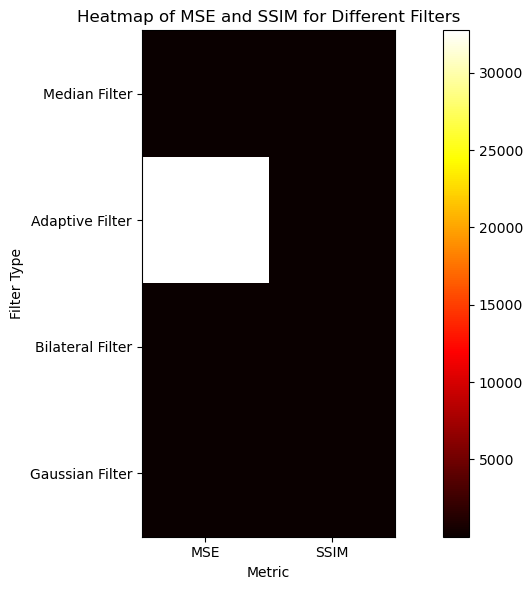

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_nl_means, estimate_sigma

# Assuming 'control_image' and 'distorted_image' are already loaded
# Example filters for demonstration:
# Median filter
def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

# Adaptive filter (here using Non-Local Means as a placeholder)
def apply_adaptive_filter(image):
    return denoise_nl_means(image, h=1.15)  # 'h' is a placeholder

# Bilateral filter
def apply_bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

# Function to apply Gaussian Bandstop Filter (using previous code)
def apply_gaussian_bandstop(image):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Image center

    # FFT and shift to frequency domain
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Create Gaussian Bandstop Filter
    u = np.arange(0, cols)
    v = np.arange(0, rows)
    U, V = np.meshgrid(u, v)
    distance = np.sqrt((U - ccol)**2 + (V - crow)**2)

    sigma = 50  # Standard deviation (adjustable)
    gaussian_filter = np.exp(-(distance**2) / (2 * sigma**2))  # Gaussian function

    # Apply filter
    fshift_filtered = fshift * gaussian_filter

    # Inverse FFT to return to spatial domain
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_filtered = np.abs(np.fft.ifft2(f_ishift))

    return image_filtered

# Assuming filtered images already calculated
filtered_median = apply_median_filter(control_image)
filtered_adaptive = apply_adaptive_filter(control_image)
filtered_bilateral = apply_bilateral_filter(control_image)
filtered_gaussian = apply_gaussian_bandstop(control_image)

# Calculate MSE and SSIM for each filtered image
def calculate_mse(original, filtered):
    return np.mean((original - filtered) ** 2)

# Create a heatmap of MSE and SSIM for each filter
# Prepare the data for the heatmap
filters = ["Median Filter", "Adaptive Filter", "Bilateral Filter", "Gaussian Filter"]
heatmap_data = []

for filter_name in filters:
    if filter_name == "Median Filter":
        filtered = filtered_median
    elif filter_name == "Adaptive Filter":
        filtered = filtered_adaptive
    elif filter_name == "Bilateral Filter":
        filtered = filtered_bilateral
    elif filter_name == "Gaussian Filter":
        filtered = filtered_gaussian

    # MSE and SSIM for each filter
    mse = calculate_mse(control_image, filtered)
    ssim_value = ssim(control_image, filtered)

    heatmap_data.append([mse, ssim_value])

# Convert the list into a NumPy array for the heatmap
heatmap_data = np.array(heatmap_data)

# Plotting the heatmap
plt.figure(figsize=(10, 6))

# Use imshow to display the heatmap
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest')

# Set up axis labels
plt.xticks([0, 1], ["MSE", "SSIM"])
plt.yticks(np.arange(len(filters)), filters)

# Adding a color bar for heatmap scale
plt.colorbar()

# Title and labels
plt.title("Heatmap of MSE and SSIM for Different Filters")
plt.xlabel("Metric")
plt.ylabel("Filter Type")

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_nl_means
import matplotlib.pyplot as plt

# Function to calculate MSE
def calculate_mse(original, filtered):
    return np.mean((original - filtered) ** 2)

# Assuming 'control_image' is already loaded and filtered images are computed
# Example filters for demonstration:
# Median filter
def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

# Adaptive filter (Non-Local Means as a placeholder)
def apply_adaptive_filter(image):
    return denoise_nl_means(image, h=1.15)  # 'h' is a placeholder

# Bilateral filter
def apply_bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

# Apply filters to the control image
filtered_median = apply_median_filter(control_image)
filtered_adaptive = apply_adaptive_filter(control_image)
filtered_bilateral = apply_bilateral_filter(control_image)

# Calculate MSE for each filter
mse_median = calculate_mse(control_image, filtered_median)
mse_adaptive = calculate_mse(control_image, filtered_adaptive)
mse_bilateral = calculate_mse(control_image, filtered_bilateral)

# Calculate SSIM for each filter
ssim_median = ssim(control_image, filtered_median)
ssim_adaptive = ssim(control_image, filtered_adaptive)
ssim_bilateral = ssim(control_image, filtered_bilateral)

# Display the results
print(f"MSE (Median Filter): {mse_median}")
print(f"MSE (Adaptive Filter): {mse_adaptive}")
print(f"MSE (Bilateral Filter): {mse_bilateral}")

print(f"SSIM (Median Filter): {ssim_median}")
print(f"SSIM (Adaptive Filter): {ssim_adaptive}")
print(f"SSIM (Bilateral Filter): {ssim_bilateral}")


MSE (Median Filter): 5.250311111111111
MSE (Adaptive Filter): 32747.18708524928
MSE (Bilateral Filter): 21.696207407407407
SSIM (Median Filter): 0.9800529987340717
SSIM (Adaptive Filter): 0.0053124076110441145
SSIM (Bilateral Filter): 0.9167790424905198
